带伪影数据获取: 获取带伪影, 去噪后, 以及原图

/root/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device now:  cuda:0
归一化前:
torch.Size([1, 1, 240, 240])
tensor(0.1374, device='cuda:0')
原始image信息:
torch.Size([1, 240, 240])
tensor(0.1374, device='cuda:0')
归一化后:
torch.Size([1, 1, 240, 240])
tensor(0.3081, device='cuda:0')
原始image信息:
torch.Size([1, 240, 240])
tensor(0.3081, device='cuda:0')
image恢复前:
tensor(0.3081, device='cuda:0')
tensor(0.3081, device='cuda:0')
tensor(0.3081, device='cuda:0')
image恢复后:
tensor(0.1374, device='cuda:0')
tensor(0.1374, device='cuda:0')
tensor(0.3081, device='cuda:0')
loaded checkpoint dir from /DiffusionMBIR/exp/ve/fastmri_knee_320_ncsnpp_continuous/checkpoint_95.pth
lambda: 0.005
rho:    0.01


100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]


torch.Size([1, 240, 240])
tensor(0.3081, device='cuda:0')
torch.Size([1, 240, 240])
tensor(0.1374, device='cuda:0')
torch.Size([1, 240, 240])
tensor(0.1374, device='cuda:0')
torch.Size([1, 240, 240])
tensor(0.3081, device='cuda:0')
tensor(0.1374, device='cuda:0')
tensor(0.1374, device='cuda:0')
tensor(0.1374, device='cuda:0')


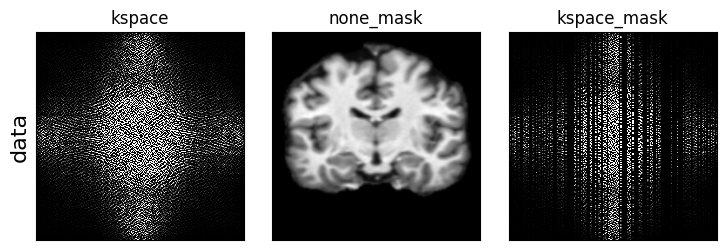

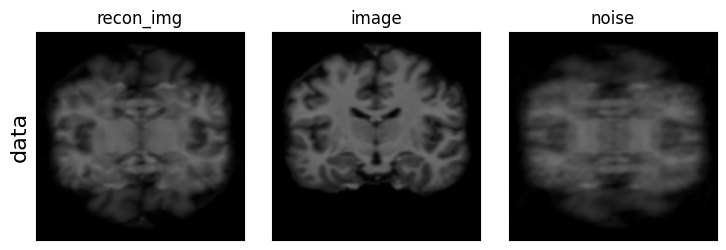

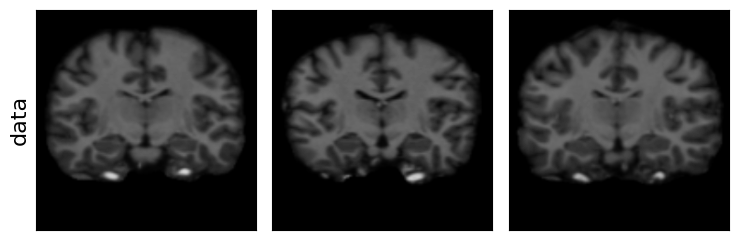

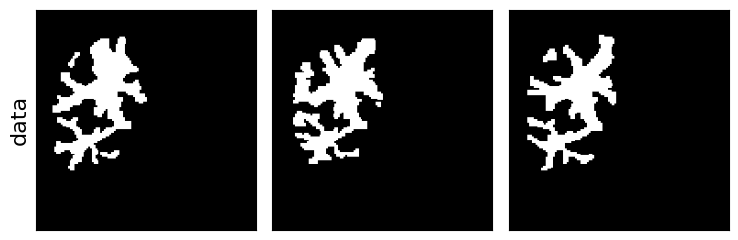

In [1]:
import math
import itertools
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import einops as E
import torch
import os

from pathlib import Path
from models import utils as mutils
import sampling as sampling
from sde_lib import VESDE
from sampling import (ReverseDiffusionPredictor,
                    LangevinCorrector,
                    LangevinCorrectorCS)
from models import ncsnpp
from itertools import islice
from losses import get_optimizer
import datasets as datasets
import time
import controllable_generation_TV as controllable_generation_TV
from utils import restore_checkpoint, fft2, ifft2, show_samples_gray, get_mask, clear
import torch.nn as nn
from models.ema import ExponentialMovingAverage
from scipy.io import savemat, loadmat
import importlib
import torchvision
from torchvision.transforms import Resize

m_gpu=0
os.environ['CUDA_VISIBLE_DEVICES'] = '%d' % m_gpu
torch.cuda.set_device(m_gpu)
torch.cuda.is_available()
torch.cuda.current_device()
device = torch.device(torch.cuda.current_device())
np.random.seed(363)
torch.manual_seed(363)
torch.cuda.manual_seed(363)
print("device now: ", device)

def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))
    
    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
        axes = axes.reshape(1, cols)
    
    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    
    if title:
        plt.suptitle(title, fontsize=20)
            
    plt.tight_layout()

# 设置类别
catgory = 1

def eval(catgory = catgory, acc_factor = 6.0, center_fraction = 0.15):
  import UniverSeg.example_data.oasis
  import UniverSeg.example_data as example_data

  # catgory = 8 12 13 (17*) (23**)
  # catgory = 10 ############################################################ 类别
  d_support = example_data.oasis.OASISDataset('support', label=catgory)
  d_test = example_data.oasis.OASISDataset('test', label=catgory)
  
  support_images, support_labels = zip(*itertools.islice(d_support, 10))
  support_images = torch.stack(support_images).to(device)
  support_labels = torch.stack(support_labels).to(device)

  # select an image, label test pair
  # idx = np.random.permutation(len(d_test))[0]
  idx = 0
  image, label = d_test[idx]
  image, label = image.to(device), label.to(device)

  # 统一resize到240
  from torchvision.transforms import Resize
  torch_resize = Resize([240,240])
  image = torch_resize(image)
  support_images = torch_resize(support_images)
  label = torch_resize(label)
  support_labels = torch_resize(support_labels)


  ###############################################
  # Configurations
  ###############################################
  num_scales = 1000
  ckpt_num = 95
  N = num_scales

  img_size = 240
  h = w = 240
  batch_size = 1

  # parameters for Fourier CS recon
  mask_type = 'uniform1d'

  ######################################################################################################
  img = image.unsqueeze(dim=0)
  all_img = img
  print("归一化前:")
  print(all_img.size())
  print(all_img.mean())

  print("原始image信息:")
  print(image.size())
  print(image.mean())

  # normalize the volume to be in proper range
  vmax = all_img.max()
  all_img /= (vmax + 1e-5)
  print("归一化后:")
  print(all_img.size())
  print(all_img.mean())

  img = all_img
  b = img.shape[0]

  print("原始image信息:")
  print(image.size())
  print(image.mean())

  kspace = fft2(img)
  
  # generate mask
  mask = get_mask(torch.zeros(1, 1, h, w), img_size, batch_size,
                  type=mask_type, acc_factor=acc_factor, center_fraction=center_fraction)
  mask = mask.to(img.device)
  mask = mask.repeat(b, 1, 1, 1)

  # undersampling
  none_mask = torch.real(ifft2(kspace))#直接ifft2回去用于和加了mask后的图像进行对比
  kspace = torch.real(kspace)#画k空间中的图像
  under_kspace = kspace * mask
  kspace_mask = torch.real(under_kspace)#画加了噪声的k空间的图像
  under_img = torch.real(ifft2(under_kspace))
  
  visualize_tensors({'data': [kspace, none_mask,kspace_mask]}, col_wrap=3, col_names=['kspace','none_mask','kspace_mask'])
  
#   sample=95
#   fig, axes = plt.subplots(nrows=1, ncols=3)
#   axes[0].matshow(none_mask[0][0].cpu().numpy(),cmap='gray')
#   axes[1].matshow(kspace[0][0].cpu().numpy(),cmap='gray')
#   axes[2].matshow(kspace_mask[0][0].cpu().numpy(),cmap='gray')

  print("image恢复前:")
  print(image.mean())
  print(img.mean())
  print(under_img.mean())

  image *= (vmax + 1e-5)
  
  print("image恢复后:")
  print(image.mean())
  print(img.mean())
  print(under_img.mean())

  # 推理损坏的图像 ###############################################
  query = under_img[0]

  # run inference
  from UniverSeg.universeg import universeg
  model = universeg(pretrained=True)
  _ = model.to(device)
  logits = model(query[None], support_images[None], support_labels[None])[0].to('cpu')
  pred = torch.sigmoid(logits)

  # visualize
  res = {'data': [query, label, pred, pred > 0.5]}
  titles = col_names=['noise', 'label', 'pred (soft)', 'pred (hard)']
  # visualize_tensors(res, col_wrap=4, col_names=titles)

  # 推理原始的图像 ###############################################
  query = img[0]

  # run inference
  logits = model(query[None], support_images[None], support_labels[None])[0].to('cpu')
  pred = torch.sigmoid(logits)

  # visualize
  res = {'data': [query, label, pred, pred > 0.5]}
  titles = col_names=['noise', 'label', 'pred (soft)', 'pred (hard)']
  # visualize_tensors(res, col_wrap=4, col_names=titles)

  return image, label, support_images, support_labels, img, under_img, under_kspace, vmax, mask

image, label, support_images, support_labels, img, under_img, under_kspace, vmax, mask = eval(catgory = catgory, acc_factor = 2.0, center_fraction = 0.05)

def denoise(under_img=under_img, under_kspace=under_kspace, mask=mask):
  ###############################################
  # Configurations
  ###############################################
  problem = 'Fourier_CS_3d_admm_tv'
  config_name = 'fastmri_knee_320_ncsnpp_continuous'
  sde = 'VESDE'
  num_scales = 1000
  ckpt_num = 95
  N = num_scales

  if sde.lower() == 'vesde':
    # from configs.ve import fastmri_knee_320_ncsnpp_continuous as configs
    configs = importlib.import_module(f"configs.ve.{config_name}")
    ckpt_filename = f"/DiffusionMBIR/exp/ve/fastmri_knee_320_ncsnpp_continuous/checkpoint_95.pth"
    config = configs.get_config()
    config.model.num_scales = num_scales
    sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
    sde.N = N
    sampling_eps = 1e-5

  config.device = device

  img_size = 240
  h = w = 240
  batch_size = 1
  config.training.batch_size = batch_size
  predictor = ReverseDiffusionPredictor
  corrector = LangevinCorrector
  probability_flow = False
  snr = 0.16
  n_steps = 1

  # parameters for Fourier CS recon
  mask_type = 'uniform1d'
  use_measurement_noise = False
  # acc_factor = 6.0 ######################################################################## 采样速率
  # center_fraction = 0.15

  # ADMM TV parameters
  lamb_list = [0.005]
  rho_list = [0.01]

  random_seed = 0

  sigmas = mutils.get_sigmas(config)
  scaler = datasets.get_data_scaler(config)
  inverse_scaler = datasets.get_data_inverse_scaler(config)
  score_model = mutils.create_model(config)

  optimizer = get_optimizer(config, score_model.parameters())
  ema = ExponentialMovingAverage(score_model.parameters(),
                                decay=config.model.ema_rate)
  state = dict(step=0, optimizer=optimizer,
              model=score_model, ema=ema)
  state = restore_checkpoint(ckpt_filename, state, config.device, skip_sigma=True)
  ema.copy_to(score_model.parameters())

  for lamb in lamb_list:
    for rho in rho_list:
        print(f'lambda: {lamb}')
        print(f'rho:    {rho}')

        pc_fouriercs = controllable_generation_TV.get_pc_radon_ADMM_TV_mri(sde,
                                                                          predictor, corrector,
                                                                          inverse_scaler,
                                                                          mask=mask,
                                                                          lamb_1=lamb,
                                                                          rho=rho,
                                                                          img_shape=img.shape,
                                                                          snr=snr,
                                                                          n_steps=n_steps,
                                                                          probability_flow=probability_flow,
                                                                          continuous=config.training.continuous)

        x = pc_fouriercs(score_model, scaler(under_img), measurement=under_kspace)

  return x

x= denoise(under_img=under_img, under_kspace=under_kspace, mask=mask)

for i, recon_img in enumerate(x):
    print(recon_img.size())
    print(recon_img.mean())

    print(image.size())
    print(image.mean())

    print(img[i].size())
    print(img[i].mean())

    print(under_img[i].size())
    print(under_img.mean())

image_pro = image
recon_img_pro = x[0]*(vmax + 1e-5)
under_img_pro = under_img[0]*(vmax + 1e-5)

print(image_pro.mean())
print(recon_img_pro.mean())
print(under_img_pro.mean())

visualize_tensors({'data': [recon_img_pro, image_pro, under_img_pro]}, col_wrap=3, col_names=['recon_img', 'image', 'noise'])
visualize_tensors({'data': [support_images[0], support_images[1],support_images[2]]}, col_wrap=3, col_names=['','',''])
visualize_tensors({'data': [support_labels[0], support_labels[1],support_labels[2]]}, col_wrap=3, col_names=['','',''])

  

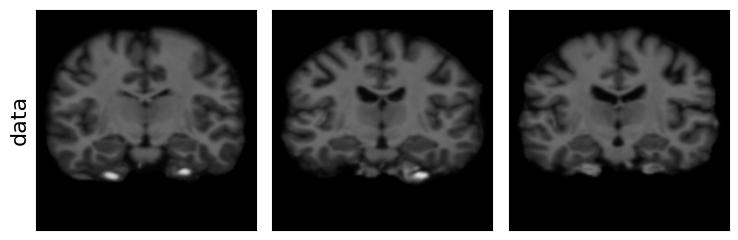

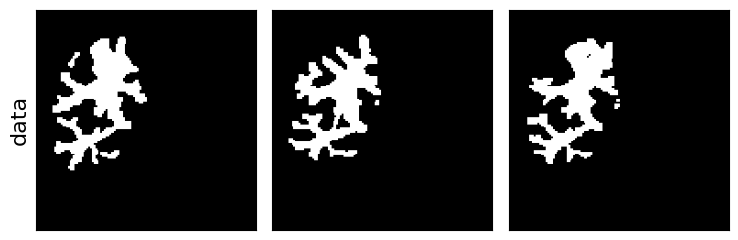

In [5]:
visualize_tensors({'data': [support_images[0], support_images[3],support_images[7]]}, col_wrap=3, col_names=['','',''])
visualize_tensors({'data': [support_labels[0], support_labels[3],support_labels[7]]}, col_wrap=3, col_names=['','',''])


In [ ]:
print(recon_img_pro.size(), image_pro.size(), under_img_pro.size())

torch.Size([1, 240, 240]) torch.Size([1, 240, 240]) torch.Size([1, 240, 240])


Dice 和 Pixel Acc函数

In [ ]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

def accuracy_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    total_pixels = 240 * 240
    correct_pixels = torch.sum(y_pred == y_true)
    accuracy = correct_pixels / total_pixels
    return accuracy.item()

# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)
    max_score = 0
    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits   

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)#clip有必要吗，经过round后已经在0,1之间了

    #  score
    score = dice_score(hard_pred, label)
    acc = accuracy_score(hard_pred, label)
    if score > max_score:
        my_img = hard_pred.cpu()
    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score,
            'acc': acc},my_img

Ours方法评估(注意所有方法都在同一个带伪影样本上评估)

In [ ]:
from collections import defaultdict

results = defaultdict(list)

from UniverSeg.universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

print(recon_img_pro.size(), image_pro.size(), under_img_pro.size())

#返回最好的图片的效果
vals, our_img = inference(model, recon_img_pro, label, support_images, support_labels)
for k, v in vals.items():
    results[k].append(v)


# visualize the results, along with their scores
scores = results.pop('score')   
print("Dice score: ", np.array(scores).mean())
acc = results.pop('acc')
print("Pixel accuracy: ", np.array(acc).mean())

torch.Size([1, 240, 240]) torch.Size([1, 240, 240]) torch.Size([1, 240, 240])
Dice score:  0.8141646981239319
Pixel accuracy:  0.9577257037162781


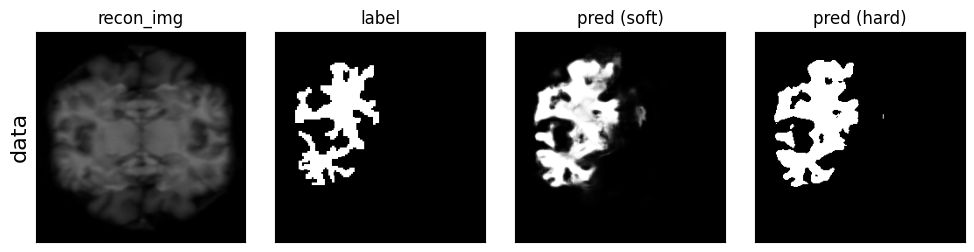

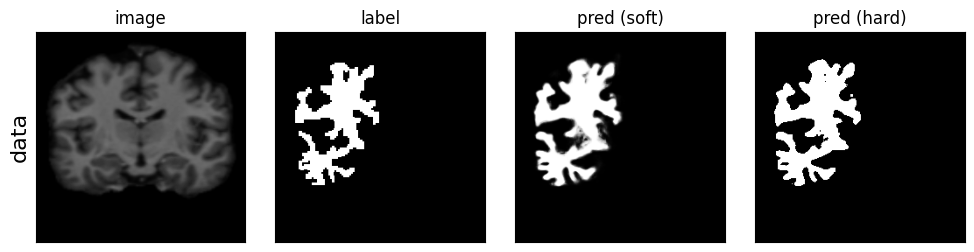

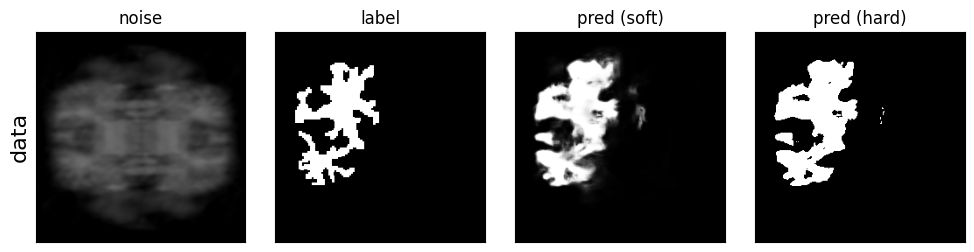

In [ ]:
from UniverSeg.universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

# 推理recon_img ###############################################
query = recon_img_pro
# run inference
logits = model(query[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)
# visualize
res = {'data': [query, label, pred, pred > 0.5]}
titles = col_names=['recon_img', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

# 推理原始图像 ###############################################
query = image_pro
# run inference
logits = model(query[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)
# visualize
res = {'data': [query, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

# 推理损坏图像 ###############################################
query = under_img_pro
# run inference
logits = model(query[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)
# visualize
res = {'data': [query, label, pred, pred > 0.5]}
titles = col_names=['noise', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

评估UniverSeg

In [ ]:
vals,universeg_img = inference(model, under_img_pro, label, support_images, support_labels)
for k, v in vals.items():
    results[k].append(v)

# visualize the results, along with their scores
scores = results.pop('score')    
print("Dice score: ", np.array(scores).mean())
acc = results.pop('acc')
print("Pixel accuracy: ", np.array(acc).mean())

Dice score:  0.8008179068565369
Pixel accuracy:  0.9543402791023254


UNet评估

In [ ]:
from method_unet import UNet
from method_deeplabv3 import PSPNet
# 统一resize到240
from torchvision.transforms import Resize
torch_resize = Resize([240,240])

 # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

def accuracy_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    total_pixels = 240 * 240
    correct_pixels = torch.sum(y_pred == y_true)
    accuracy = correct_pixels / total_pixels
    return accuracy.item()

# run inference and compute losses for one test image
@torch.no_grad()
def inference_other(model, image, label):
    image, label = image.to(device).unsqueeze(dim=0), label.to(device).unsqueeze(dim=0)
    # inference
    soft_pred = model(image)    
    hard_pred = soft_pred.round().clip(0,1).squeeze(dim=0)
    max_score = 0
    #  score
    # print(hard_pred.size())
    # print(label.size())
    score = dice_score(hard_pred, label.squeeze(dim=0))
    acc = accuracy_score(hard_pred, label.squeeze(dim=0))
    if score > max_score:
        my_img = hard_pred.cpu()
    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score,
            'acc': acc
            # 'my_img':
            },my_img

def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        loss_total=[]
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            inputs = torch_resize(inputs)
            labels = torch_resize(labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_total.append(loss.item())
        print(sum(loss_total))
        
def test(model, d_test, flag):
    if flag:
        model.eval()
    n_predictions = 1
    results = defaultdict(list)
    vals,model_img = inference_other(model, under_img_pro, label)
    for k, v in vals.items():
        # if k == 'my_img':
        #    model_img = torch.Tensor(results[k]).view(1, 1, -1).permute(1, 2, 0)
        # else:
        results[k].append(v)
    
    # visualize the results, along with their scores
    scores = results.pop('score')    
    print("Dice score: ", np.array(scores).mean())
    acc = results.pop('acc')
    print("Pixel accuracy: ", np.array(acc).mean())
    return model_img

In [ ]:
def UNet_eval(catgory=catgory):
    # # 设置设备
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建训练和测试数据加载器
    import UniverSeg.example_data as example_data
    import UniverSeg.example_data.oasis
    d_support = example_data.oasis.OASISDataset('support', label=catgory)
    d_test = example_data.oasis.OASISDataset('test', label=catgory)

    # print(len(d_support))
    # print(len(d_test))
    #使用dataloader构造train_dataloader
    train_dataloader = torch.utils.data.DataLoader(d_support,
                                            batch_size=2,
                                            shuffle=True, #每个epoch打乱一次
                                            num_workers=1,
                                            drop_last=True
                                            )

    # 初始化模型、损失函数和优化器
    unet_model = UNet(1, 1).to(device)
    DeepLabV3_model = PSPNet(nInputChannels = 1, num_classes = 1, os = 8, backbone="resnet50", pretrained = False, aux_branch=False).to(device)

    model = unet_model

    if model == DeepLabV3_model:
        flag = 1
    else:
        flag = 0

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 训练模型
    import time
    start_time = time.time()
    train(model, train_dataloader, criterion, optimizer, num_epochs=10)
    print('Training time: %.1f s' % (time.time() - start_time))
    # 在伪影数据上评估模型
    unet_img = test(model, d_test, flag)
    return  unet_img

In [ ]:
unet_img = UNet_eval()

/root/miniconda3/envs/myenv/lib/python3.8/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


13.085573621094227
5.200545035302639
4.774353450164199
4.535213895142078
4.452532548457384
4.384317005053163
4.274842640385032
4.245993034914136
4.187890253961086
4.176091622561216
Training time: 74.0 s
Dice score:  0.6621919870376587
Pixel accuracy:  0.9388368129730225


评估Deeplabv3

In [ ]:
def Deeplabv3_eval(catgory=catgory):
    # # 设置设备
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建训练和测试数据加载器
    import UniverSeg.example_data as example_data
    import UniverSeg.example_data.oasis
    d_support = example_data.oasis.OASISDataset('support', label=catgory)
    d_test = example_data.oasis.OASISDataset('test', label=catgory)

    # print(len(d_support))
    # print(len(d_test))
    #使用dataloader构造train_dataloader
    train_dataloader=torch.utils.data.DataLoader(d_support,
                                            batch_size=2,
                                            shuffle=True, #每个epoch打乱一次
                                            num_workers=1,
                                            drop_last=True
                                            )

    # 初始化模型、损失函数和优化器
    unet_model = UNet(1, 1).to(device)
    DeepLabV3_model = PSPNet(nInputChannels = 1, num_classes = 1, os = 8, backbone="resnet50", pretrained = False, aux_branch=False).to(device)

    model = DeepLabV3_model

    if model == DeepLabV3_model:
        flag = 1
    else:
        flag = 0

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 训练模型
    import time
    start_time = time.time()
    train(model, train_dataloader, criterion, optimizer, num_epochs=10)
    print('Training time: %.1f s' % (time.time() - start_time))
    # 在伪影数据上评估模型
    dl3 = test(model, d_test, flag)
    return dl3

In [ ]:
dl3 = Deeplabv3_eval()

17.66140117868781
7.485440246760845
6.721845597028732
6.323932323604822
6.163272835314274
5.903247088193893
5.778945963829756
5.732314363121986
5.843684945255518
5.6220306642353535
Training time: 69.1 s
Dice score:  0.46946847438812256
Pixel accuracy:  0.925486147403717


In [ ]:
def visualize_img_tensor(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))
    
    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
        axes = axes.reshape(1, cols)
    
    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    
    if title:
        plt.suptitle(title, fontsize=20)
            
    plt.tight_layout()

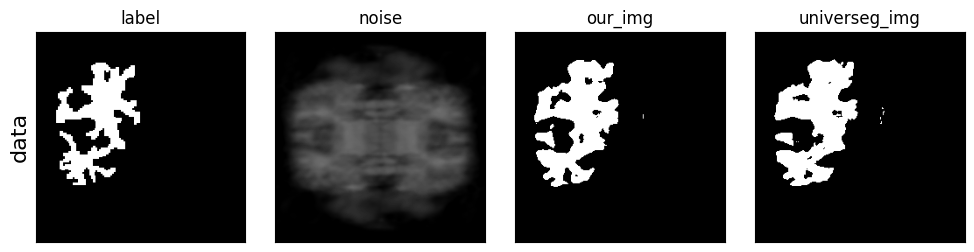

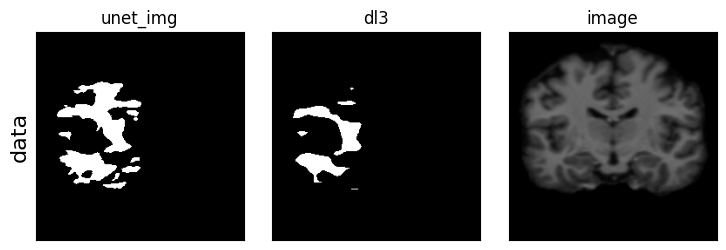

In [ ]:
visualize_img_tensor({
    'data': [label,under_img_pro,our_img, universeg_img]},
        col_wrap=4,
        col_names=['label','noise','our_img','universeg_img'
     ])
visualize_img_tensor({
    'data': [unet_img, dl3,image_pro]},
        col_wrap=3,
        col_names=['unet_img', 'dl3','image'
    ])